- Start with general stuff

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import h5py, os, sys
from tqdm import tqdm

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from utilities.corporate_design_colors_v4 import cmap
import utilities.old.corporate_design_colors_v3 as cpd

In [4]:
def bin_y_over_x(x, y, x_bins):
    
    # Apply binning based on histogram function
    x_nu = np.append(x_bins, 2*x_bins[-1]-x_bins[-2])
    x_nu = x_nu - (x_nu[1] - x_nu[0])/2
        # Instead of N_x, gives fixed axis.
        # Solves issues with wider ranges, than covered by data
    _count, _ = np.histogram(x,
                             bins = x_nu,
                             weights=None)
    _count = np.array(_count, dtype='float64')
    _count[_count==0] = np.nan

    _sum, _ = np.histogram(x,
                           bins = x_nu,
                           weights = y)    
    return _sum/_count

- define constants

In [5]:
h = 6.62607015e-34  # V * A * s²
e = 1.602176634e-19 #     A * s
Vgap = 191e-6       # V
Delta = Vgap*e      # V * A * s
G_0 = 2*e**2/h      # A / V
R_0 = h/(2*e**2)    # V / A

- get theoretical IV curves from Carlos

In [6]:
path = 'CarlosIV'
arr = os.listdir(f'{path}')
arr.remove('iv.in')
arr.remove('iv.for')

v_norm = np.linspace(0,5.99,600)
V_norm = np.concatenate((-np.flip(v_norm)[:-1],v_norm))
T_theo = np.zeros(len(arr)+1, dtype='float64')
I_norm_theo = np.zeros((len(T_theo), len(v_norm)), dtype='float64')

for i in range(len(arr)):
    temp = arr[i][:-4]
    value = int(temp)*10**(-len(temp)+1)
    T_theo[i+1] = value

for i, a in enumerate(arr):
    v_norm_theo = np.genfromtxt(f'{path}/{a}')[:,0]
    i_norm_theo = np.genfromtxt(f'{path}/{a}')[:,1]
    I_norm_theo[i+1,:] = bin_y_over_x(v_norm_theo, i_norm_theo, v_norm)

I_theo = np.concatenate((-np.flip(I_norm_theo, axis=1)[:,:-1],I_norm_theo), axis=1)

dIdV_norm_theo = np.gradient(I_norm_theo, v_norm, axis=1)
dIdV_theo = np.gradient(I_theo, V_norm, axis=1)

indices = np.argsort(T_theo)
T_theo = T_theo[indices]
I_theo = I_theo[indices,:]
I_norm_theo = I_norm_theo[indices]
dIdV_theo = dIdV_theo[indices,:]

<Figure size 640x480 with 0 Axes>

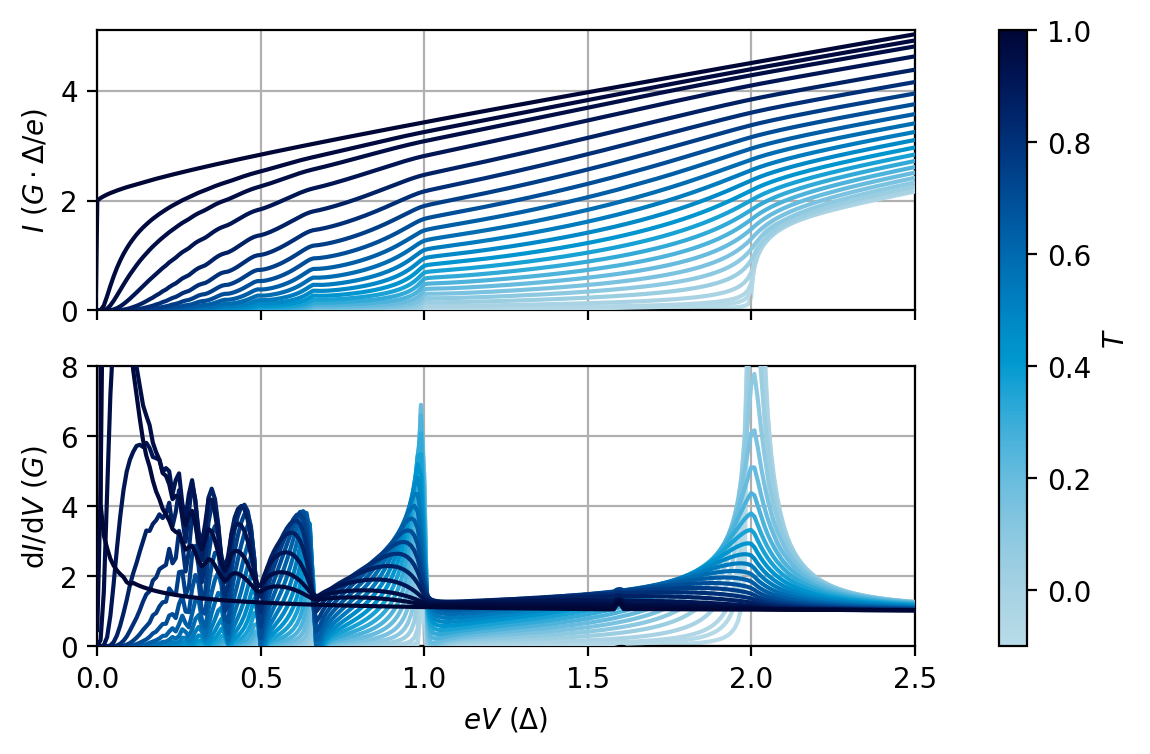

In [7]:
%matplotlib inline
plt.figure(1)
fig, axs = plt.subplots(figsize=(6,4), ncols=2, nrows=2, dpi=200,
        gridspec_kw={"width_ratios":[5.8,.2]})
gs = axs[0,1].get_gridspec()
ax11 = axs[0,0]
ax12 = axs[1,0]

black_lim = .1

t, _ = np.meshgrid(T_theo, np.ones((47,)))
cmap = cpd.images(inverse=True, clim=[.1, .8])
im = axs[0,1].imshow(t, cmap = cmap, clim=(1, 0))
axs[0,1].remove()
axs[1,1].remove()
ax_clb = fig.add_subplot(gs[:,-1])

for i, T in enumerate(T_theo):
    if i%2==1:
        I = I_theo[i,:]/T
        dIdV = np.gradient(I, V_norm)
        ax11.plot(V_norm, I, '-',label=f'{T:0.03}', color = cmap(T), zorder=i)
        ax12.plot(V_norm, dIdV, '-',label=f'{T:0.03}', color = cmap(T), zorder=i)

cbar=fig.colorbar(im, label=r'$T$', cax=ax_clb)

ax11.set_xticklabels([])
ax11.grid()
ax12.grid()
ax11.set_xlim(0,2.5)
ax12.set_xlim(0,2.5)
ax11.set_ylim(0,5.1)
ax12.set_ylim(0,8)

ax11.set_ylabel(r'$I\ (2e\Delta/h)$')
# G_0 = 2*e**2/h      # A / V
ax11.set_ylabel(r'$I\ (G \cdot \Delta/e)$')
ax12.set_xlabel(r'$eV\ (\Delta)$')
ax12.set_ylabel(r'd$I/$d$V\ (G_0)$')
ax12.set_ylabel(r'd$I/$d$V\ (G)$')

plt.savefig('CarlosIV_norm.png')

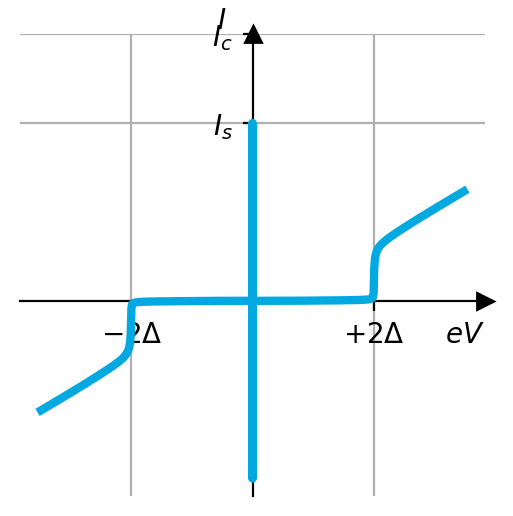

In [8]:
%matplotlib inline
I = I_norm_theo[1,:]/T_theo[1]
V = np.linspace(0,5.99,600)

from numpy import size
from scipy.signal import savgol_filter

I_filtered = savgol_filter(I[:150], 100,1)

I = np.concatenate([I_filtered, I[150:]])
I = I/4
I_c=1.33#*np.pi

I = np.concatenate([[I_c], I[:350]])
V = np.concatenate([[0], V[:350]])

VV = np.concatenate([-np.flip(V),V])
II = np.concatenate([-np.flip(I),I])


# dd = np.gradient(II, VV)
# plt.plot(VV,dd)



fig, ax = plt.subplots(figsize=(3,3), dpi=200)
# Move the left and bottom spines to x = 0 and y = 0, respectively.
ax.spines[["left", "bottom"]].set_position(("data", 0))
# Hide the top and right spines.
ax.spines[["top", "right"]].set_visible(False)

# Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
# case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
# respectively) and the other one (1) is an axes coordinate (i.e., at the very
# right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
# actually spills out of the axes.
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

ax.plot(VV,II, '-', lw=3, color=cpd.curves()(1), zorder=3)

# ax.set_xlabel(r'$eV (\Delta)$', loc='right')
# ax.set_ylabel(r'$I (G\Delta/e)$', loc='top')
ax.set_xlabel(r'$eV$', loc='right', labelpad=-10)
ax.set_ylabel(r'$I$', loc='top', rotation=0, labelpad=-5)

ax.set_xticks([])
ax.set_yticks([])

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# ax.plot([-2, -2],ylim, zorder = 1, color='lightgrey')
# ax.plot([+2, +2],ylim, zorder = 1, color='lightgrey')
# # ax.annotate(r'$-2\Delta$', (-1.85, -4), color='grey')
# # ax.annotate(r'$+2\Delta$', (2.15, -4), color='grey')

# ax.plot(xlim,[I_c, I_c], zorder = 1, color='lightgrey')
# ax.plot(xlim,ylim, zorder = 1, color='lightgrey')

ax.set_xticks([-2,2], labels=[r'$-2\Delta$', r'$+2\Delta$'])
ax.set_yticks([I_c,2], labels=[r'$I_s$', r'$I_c$'])
ax.grid()

# ax.grid()

In [9]:
%matplotlib inline

import numpy as np
from scipy.signal import savgol_filter

cut_off = 350

I_low_t = I_norm_theo[1,:cut_off]/T_theo[1]
I_high_t = I_norm_theo[len(T_theo)-1,:cut_off]

V = np.linspace(0,5.99,600)
V = np.concatenate([[0], V[:cut_off]])

I_filtered = savgol_filter(I_low_t[:150], 100,1)
I_low_t = np.concatenate([I_filtered, I_low_t[150:]])

I_s = 1.33
I_c = 2
I_mixed = np.concatenate([[I_s], I_low_t])
I_low_t = np.concatenate([[0], I_low_t])
I_high_t = np.concatenate([[I_c], I_high_t])

V = np.concatenate([-np.flip(V),V])
I_mixed = np.concatenate([-np.flip(I_mixed),I_mixed])
I_low_t = np.concatenate([-np.flip(I_low_t),I_low_t])
I_high_t = np.concatenate([-np.flip(I_high_t),I_high_t])

dIdV_low_t = np.gradient(I_low_t, V)
dIdV_high_t = np.gradient(I_high_t, V)
dIdV_high_t = dIdV_high_t - 1

V_dIdV = np.copy(V)
todel = [189, 190, 339, 340, 361, 362, 511, 512]
V_dIdV = np.delete(V_dIdV, todel)
dIdV_low_t = np.delete(dIdV_low_t, todel)
dIdV_high_t = np.delete(dIdV_high_t, todel)
dIdV_mixed = dIdV_low_t + dIdV_high_t*I_s/I_c

V.shape, I_mixed.shape, I_low_t.shape, I_high_t.shape

/Users/oliver/Documents/p5control-bluefors-evaluation/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1290: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/oliver/Documents/p5control-bluefors-evaluation/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1290: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/oliver/Documents/p5control-bluefors-evaluation/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1291: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/oliver/Documents/p5control-bluefors-evaluation/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1291: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/oliver/Documents/p5control-bluefors-evaluation/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1292: RuntimeWarning: divi

((702,), (702,), (702,), (702,))

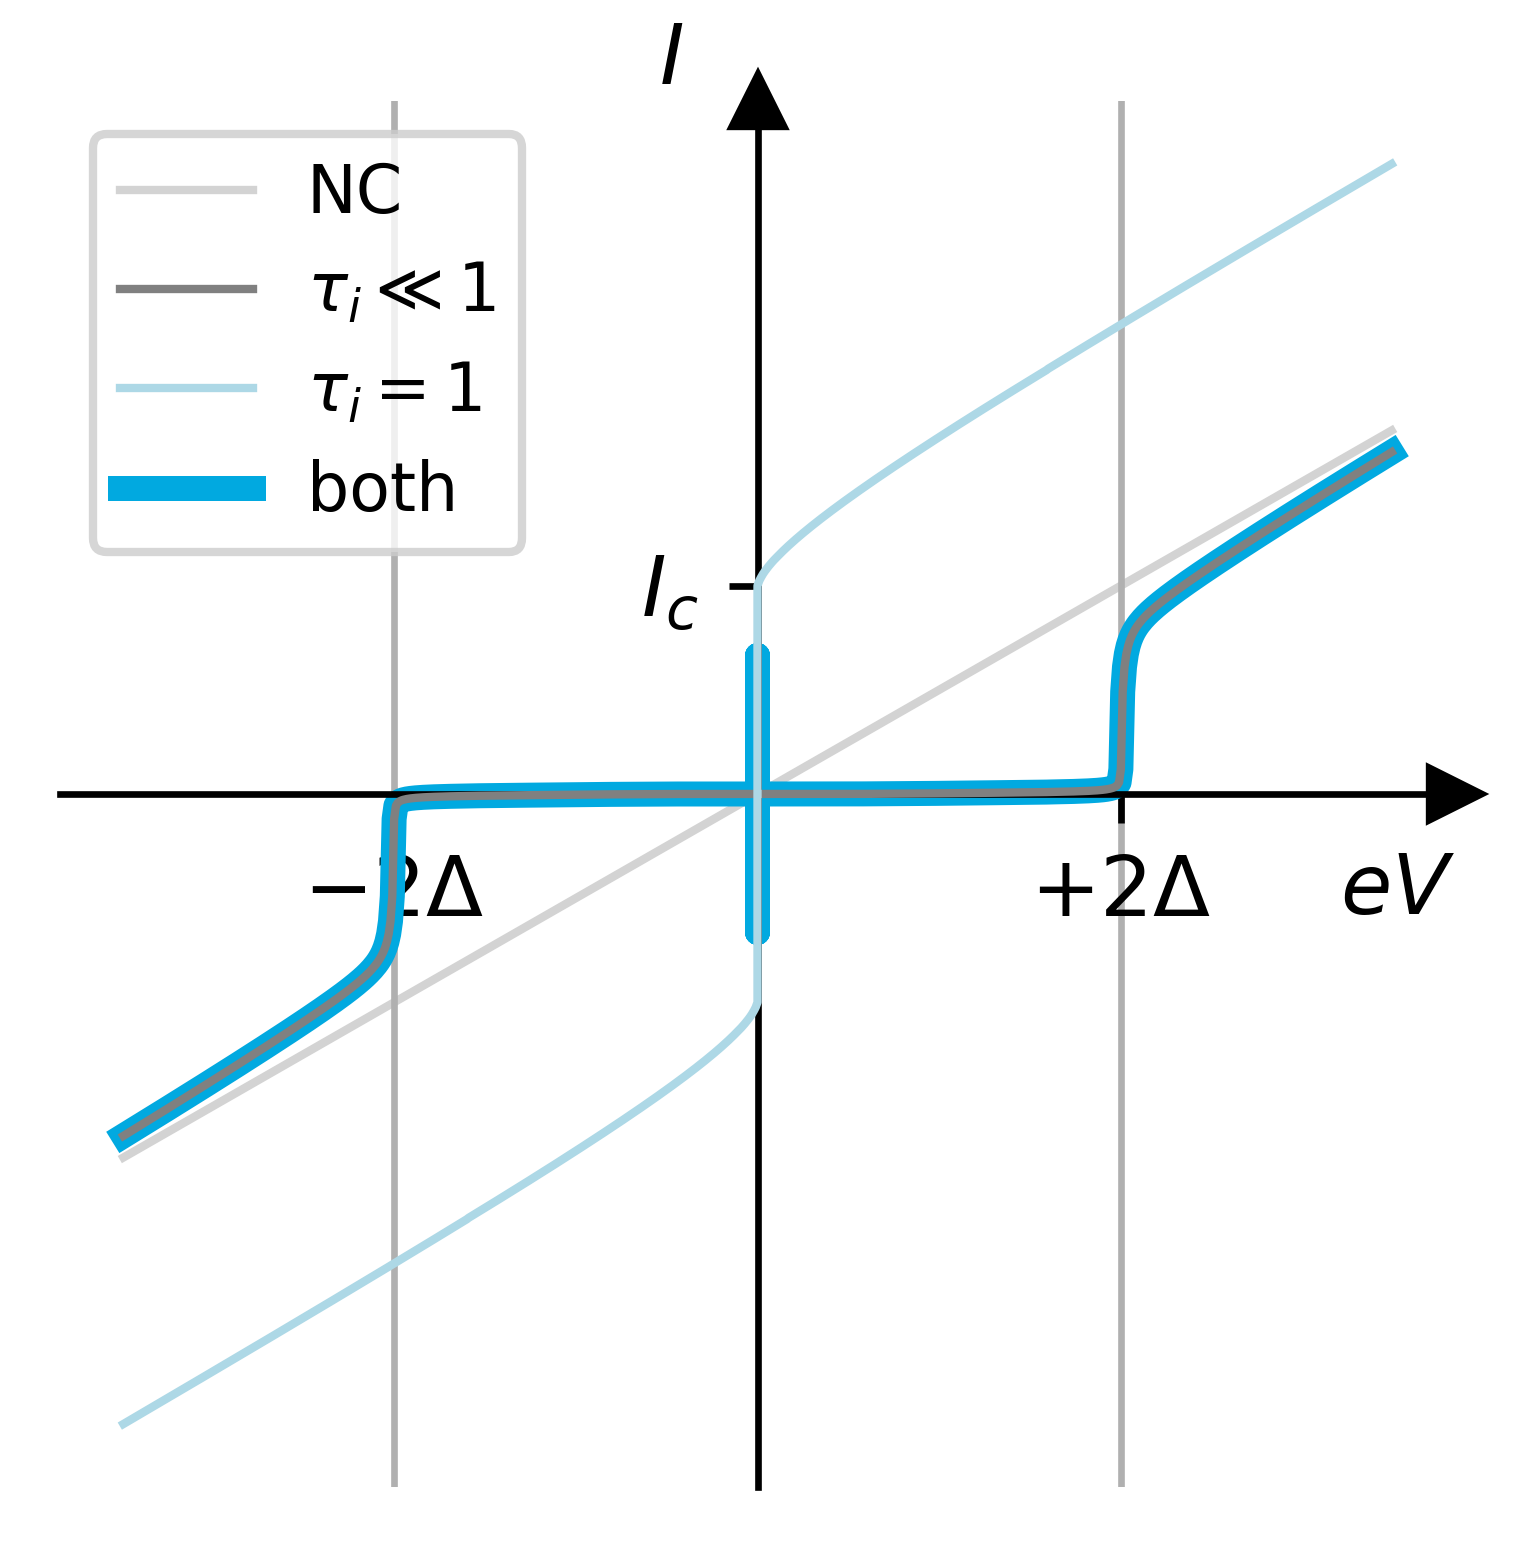

In [35]:
fig, ax = plt.subplots(figsize=(3,3), dpi=600)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

ax.plot(V,V, zorder = 1, color='lightgrey', lw=1, label='NC')
ax.plot(V,I_low_t, '-', lw=1, color='grey', zorder=3, label=r'$\tau_i \ll 1$')
ax.plot(V,I_high_t, '-', lw=1, color='lightblue', zorder=3, label=r'$\tau_i = 1$')
ax.plot(V,I_mixed, '-', lw=3, color=cpd.curves()(1), zorder=2, label=r'both', markersize=1)

ax.set_xlabel(r'$eV$', loc='right', labelpad=-10)
ax.set_ylabel(r'$I$', loc='top', rotation=0, labelpad=-5)

ax.set_xticks([])
ax.set_yticks([])

xlim = ax.get_xlim()
ylim = ax.get_ylim()


ax.set_xticks([-2,2], labels=[r'$-2\Delta$', r'$+2\Delta$'])
# ax.set_xticks([-2], labels=[r'$-2\Delta$'])
ax.set_yticks([I_s,I_c], labels=[r'$I_s$', r'$I_c$'])
ax.set_yticks([I_c], labels=[ r'$I_c$'])
# ax.grid()
ax.legend(prop={'size': 8})

ax.grid(axis='x')

plt.savefig('I_low_high_t.png')

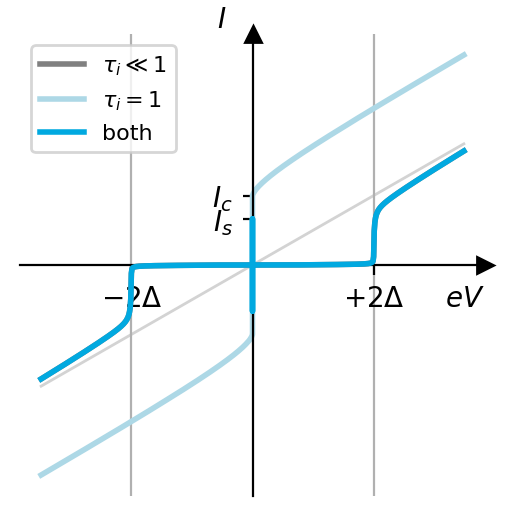

In [274]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

ax.plot(V,V, zorder = 1, color='lightgrey', lw=1)
ax.plot(V,I_low_t, '-', lw=2, color='grey', zorder=2, label=r'$\tau_i \ll 1$')
ax.plot(V,I_high_t, '-', lw=2, color='lightblue', zorder=2, label=r'$\tau_i = 1$')
ax.plot(V,I_mixed, '-', lw=2, color=cpd.curves()(1), zorder=3, label=r'both')

ax.set_xlabel(r'$eV$', loc='right', labelpad=-10)
ax.set_ylabel(r'$I$', loc='top', rotation=0, labelpad=-5)

ax.set_xticks([])
ax.set_yticks([])

xlim = ax.get_xlim()
ylim = ax.get_ylim()


ax.set_xticks([-2,2], labels=[r'$-2\Delta$', r'$+2\Delta$'])
# ax.set_xticks([-2], labels=[r'$-2\Delta$'])
ax.set_yticks([I_s,I_c], labels=[r'$I_s$', r'$I_c$'])
# ax.set_yticks([I_c], labels=[ r'$I_c$'])
# ax.grid()
ax.legend(prop={'size': 8})

ax.grid(axis='x')
plt.savefig('I_low_high_mixed_t.png')

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_41516/2708963726.py:8: RuntimeWarning: invalid value encountered in divide
  ax.plot(V,V/V, zorder = 1, color='lightgrey', lw=1)


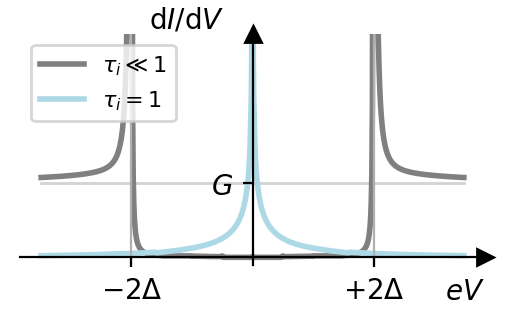

In [275]:
fig, ax = plt.subplots(figsize=(3,1.5), dpi=200)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False, zorder=3)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, zorder=3)

ax.plot(V,V/V, zorder = 1, color='lightgrey', lw=1)
ax.plot(V_dIdV, dIdV_low_t, '-', lw=2, color='grey', zorder=1, label=r'$\tau_i \ll 1$')
ax.plot(V_dIdV, dIdV_high_t, '-', lw=2, color='lightblue', zorder=1, label=r'$\tau_i = 1$')
# ax.plot(V_dIdV,dIdV_mixed, '-', lw=2, color=cpd.curves()(1), zorder=1, label=r'both')

ax.set_xlabel(r'$eV$', loc='right', labelpad=-10)
ax.set_ylabel(r'd$I/$d$V$', loc='top', rotation=0, labelpad=-5)

ax.set_xticks([])
ax.set_yticks([])

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_ylim((-.1, 3))

ax.set_xticks([-2,2], labels=[r'$-2\Delta$', r'$+2\Delta$'])
# ax.set_xticks([-2], labels=[r'$-2\Delta$'])
ax.set_yticks([I_s,I_c], labels=[r'$I_s$', r'$I_c$'])
ax.set_yticks([1], labels=[ r'$G$'])
# ax.grid()
ax.legend(loc='upper left',prop={'size': 8})

ax.grid(axis='x')

plt.savefig('dIdV_low_high_t.png')

/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_41516/1821225737.py:8: RuntimeWarning: invalid value encountered in divide
  ax.plot(V,V/V, zorder = 1, color='lightgrey', lw=1)


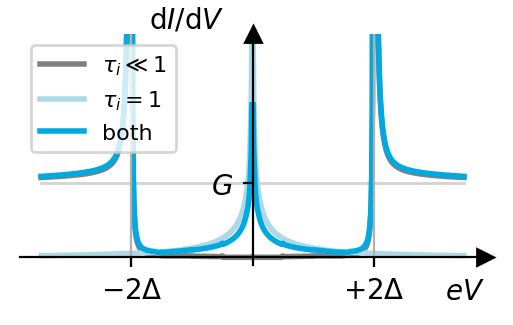

In [277]:
fig, ax = plt.subplots(figsize=(3,1.5), dpi=200)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False, zorder=3)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, zorder=3)

ax.plot(V,V/V, zorder = 1, color='lightgrey', lw=1)
ax.plot(V_dIdV, dIdV_low_t, '-', lw=2, color='grey', zorder=1, label=r'$\tau_i \ll 1$')
ax.plot(V_dIdV, dIdV_high_t, '-', lw=2, color='lightblue', zorder=1, label=r'$\tau_i = 1$')
ax.plot(V_dIdV,dIdV_mixed, '-', lw=2, color=cpd.curves()(1), zorder=1, label=r'both')

ax.set_xlabel(r'$eV$', loc='right', labelpad=-10)
ax.set_ylabel(r'd$I/$d$V$', loc='top', rotation=0, labelpad=-5)

ax.set_xticks([])
ax.set_yticks([])

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_ylim((-.1, 3))

ax.set_xticks([-2,2], labels=[r'$-2\Delta$', r'$+2\Delta$'])
# ax.set_xticks([-2], labels=[r'$-2\Delta$'])
ax.set_yticks([I_s,I_c], labels=[r'$I_s$', r'$I_c$'])
ax.set_yticks([1], labels=[ r'$G$'])
# ax.grid()
ax.legend(loc='upper left',prop={'size': 8})

ax.grid(axis='x')

plt.savefig('dIdV_mixed.png')

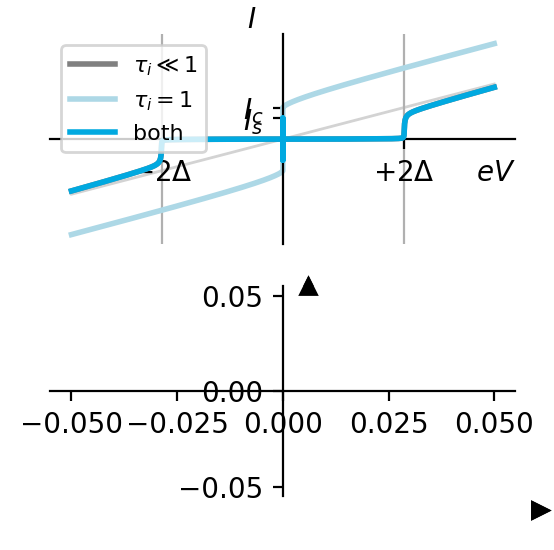

In [ ]:
fig, [ax0, ax1] = plt.subplots(2, figsize=(3,3), dpi=200)

ax0.spines[["left", "bottom"]].set_position(("data", 0))
ax0.spines[["top", "right"]].set_visible(False)
ax0.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax0.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

ax1.spines[["left", "bottom"]].set_position(("data", 0))
ax1.spines[["top", "right"]].set_visible(False)
ax1.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax1.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)



ax0.plot(V,V, zorder = 1, color='lightgrey', lw=1)
ax0.plot(V,I_low_t, '-', lw=2, color='grey', zorder=2, label=r'$\tau_i \ll 1$')
ax0.plot(V,I_high_t, '-', lw=2, color='lightblue', zorder=2, label=r'$\tau_i = 1$')
ax0.plot(V,I_mixed, '-', lw=2, color=cpd.curves()(1), zorder=3, label=r'both')

ax0.set_xlabel(r'$eV$', loc='right', labelpad=-10)
ax0.set_ylabel(r'$I$', loc='top', rotation=0, labelpad=-5)

ax0.set_xticks([])
ax0.set_yticks([])


ax0.set_xticks([-2,2], labels=[r'$-2\Delta$', r'$+2\Delta$'])
# ax.set_xticks([-2], labels=[r'$-2\Delta$'])
ax0.set_yticks([I_s,I_c], labels=[r'$I_s$', r'$I_c$'])
# ax.set_yticks([I_c], labels=[ r'$I_c$'])
# ax.grid()

ax0.legend(prop={'size': 8})

ax0.grid(axis='x')
# plt.savefig('I_low_high_mixed_t.png')

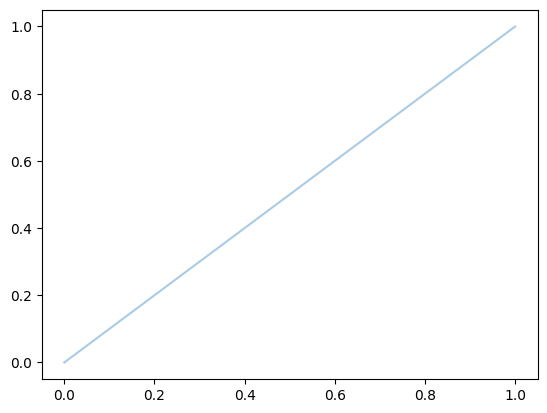

In [ ]:
seeblau = np.array([6, 154, 209])/256
seeblau = np.array([86.743,  152.566,  205.880, 256*0.5])/256

def seeblau(alpha):
    return np.array([86.743,  152.566,  205.880, 256*alpha])/256

plt.plot([0,1], [0,1],'-', color=tuple(seeblau))

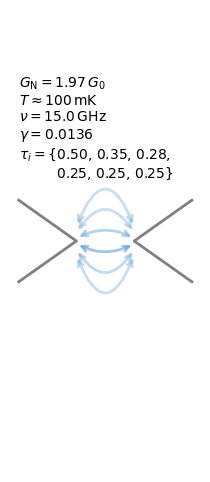

In [238]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def seeblau(alpha: float = 1.):
    return np.array([86.743,  152.566,  205.880, 256*alpha])/256

def center_highest(values):
    sorted_vals = sorted(values, reverse=True)
    center_sorted = []

    for i, val in enumerate(sorted_vals):
        # Alternate insertion left and right around center
        if i == 0:
            center_sorted.insert(len(center_sorted) // 2, val)  # max in center
        elif i % 2 == 1:
            center_sorted.insert(0, val)  # left
        else:
            center_sorted.append(val)    # right

    return center_sorted


G = 1.97 #G_0
pin_code_unsorted = [.5, .35, .28, .25, .25, .25]
T_50_200 = False
T_100 = True
Delta = None # 189 #µeV
V_omega_const = False
nu = 15.0 #15 #GHz
gamma = 0.0136 #0.0146
c= None # .4


pin_code = pin_code_unsorted.copy()
# pin_code.pop(-1)
pin_code = center_highest(pin_code)

fig, ax = plt.subplots(dpi=100, figsize=(3,6))

plt.plot([0, .5, 0], [-np.sqrt(2)/4, 0, np.sqrt(2)/4], color="grey", linewidth=2)
plt.plot([1.5, 1, 1.5], [-np.sqrt(2)/4, 0, np.sqrt(2)/4], color="grey", linewidth=2)

for i, pin in enumerate(pin_code):
    rad=(-len(pin_code)/2+i+.5)*.5
    color = seeblau(pin*.9+.1)
    arrow = patches.FancyArrowPatch(
    (.5, -rad/10), (1, -rad/10),
    connectionstyle=f"arc3,rad={rad}",
    arrowstyle='<->',
    mutation_scale=10,
    color=color,
    linewidth=2
    )
    ax.add_patch(arrow)

# Formatting
# ax.set_xlim(-2, 3)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.axis('off')
string = ''
if G is not None:
    string += r"$G_\mathrm{N}=$"+f"${G:.02f}$"+r"$\,G_0$"+"\n"
if T_50_200:
    string += r"$T=50-200\,$mK"+"\n"
if T_100:
    string += r"$T \approx 100\,$mK"+"\n"
if Delta is not None:
    string += r"$\Delta = $"+f"${Delta:d}$"+r"$\,$µeV"+"\n"
if V_omega_const:
    string += r"$V_\mathrm{out} = const.$"+"\n"
if nu is not None:
    string += r"$\nu = $"+f"${nu:.1f}$"+r"$\,$GHz"+"\n"
if gamma is not None:
    string += r"$\gamma = $"+f"${gamma:.4f}$"+"\n"
if c is not None:
    string += f"$c = {c:.1f}$"+"\n"

string += r"$\tau_i = \{$"
for i, tau in enumerate(pin_code_unsorted):
    string += rf"${tau:.2f}$"
    string += ', '
    if i==len(pin_code_unsorted)-1:
        break
    if (i+1)%3==0:
        string += "\n"+r"        $\,$"
    

string = string[:-2]+r"$\}$"

plt.annotate(string, xy=(0,0), xytext=(0, .55),)
# plt.tight_layout()
# plt.show()
plt.savefig('label.png', dpi=600)

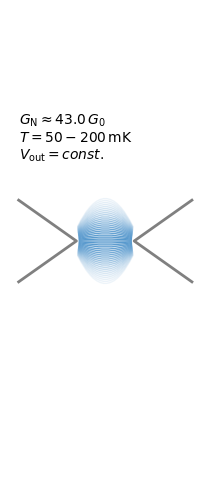

In [257]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def seeblau(alpha: float = 1.):
    return np.array([86.743,  152.566,  205.880, 256*alpha])/256

def center_highest(values):
    sorted_vals = sorted(values, reverse=True)
    center_sorted = []

    for i, val in enumerate(sorted_vals):
        # Alternate insertion left and right around center
        if i == 0:
            center_sorted.insert(len(center_sorted) // 2, val)  # max in center
        elif i % 2 == 1:
            center_sorted.insert(0, val)  # left
        else:
            center_sorted.append(val)    # right

    return center_sorted


G = 43 #G_0
pin_code_unsorted = [1, 1, 1, 1, 1, 1,1 ,1 ,1 ,1,1, 1, 1, 1, 1, 1,1 ,1 ,1 ,1,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8,.8, .5,.5,.5,.5,.5, .5,.5,.5,.5,.5, .1,.1,.1,.1,.1,.1,.1,.1]
x = np.linspace(-np.pi/2, np.pi/2, 43)
pin_code_unsorted = (np.arctan(x)+1)/2

# plt.plot(x, pin_code_unsorted)

T_50_200 = True
T_100 = False
Delta = None # 189 #µeV
V_omega_const = True
nu = None #15.0 #15 #GHz
gamma = None # 0.0197 #0.0146
c= None # .4


pin_code = pin_code_unsorted.copy()
# pin_code.pop(-1)
pin_code = center_highest(pin_code)
pin_code = np.array(pin_code)
pin_code[pin_code>1]=1
pin_code[pin_code<0]=0

fig, ax = plt.subplots(dpi=100, figsize=(3,6))

plt.plot([0, .5, 0], [-np.sqrt(2)/4, 0, np.sqrt(2)/4], color="grey", linewidth=2)
plt.plot([1.5, 1, 1.5], [-np.sqrt(2)/4, 0, np.sqrt(2)/4], color="grey", linewidth=2)

for i, pin in enumerate(pin_code):
    rad=(-len(pin_code)/2+i+.5)*.05
    color = seeblau(pin*.9+.1)
    arrow = patches.FancyArrowPatch(
        (.5, -rad/10), (1, -rad/10),
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-',
        mutation_scale=3,
        color=color,
        linewidth=1
        )
    ax.add_patch(arrow)

# Formatting
# ax.set_xlim(-2, 3)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.axis('off')
string = ''
if G is not None:
    string += r"$G_\mathrm{N}\approx$"+f"${G:.1f}$"+r"$\,G_0$"+"\n"
if T_50_200:
    string += r"$T=50-200\,$mK"+"\n"
if T_100:
    string += r"$T \approx 100\,$mK"+"\n"
if Delta is not None:
    string += r"$\Delta = $"+f"${Delta:d}$"+r"$\,$µeV"+"\n"
if V_omega_const:
    string += r"$V_\mathrm{out} = const.$"+"\n"
if nu is not None:
    string += r"$\nu = $"+f"${nu:.1f}$"+r"$\,$GHz"+"\n"
if gamma is not None:
    string += r"$\gamma = $"+f"${gamma:.4f}$"+"\n"
if c is not None:
    string += f"$c = {c:.1f}$"+"\n"

# string += r"$\tau_i = \{$"
# for i, tau in enumerate(pin_code_unsorted):
#     string += rf"${tau:.2f}$"
#     string += ', '
#     if i==len(pin_code_unsorted)-1:
#         break
#     if (i+1)%3==0:
#         string += "\n"+r"        $\,$"
    

# string = string[:-2]+r"$\}$"

plt.annotate(string, xy=(0,0), xytext=(0, .55),)
# plt.tight_layout()
# plt.show()
plt.savefig('label.png', dpi=600)

In [254]:
pin_code_unsorted

array([0.        , 0.0092202 , 0.02118166, 0.03401563, 0.04780228,
       0.06262832, 0.07858664, 0.0957756 , 0.1142976 , 0.13425681,
       0.15575578, 0.17889062, 0.20374452, 0.23037942, 0.25882605,
       0.28907266, 0.32105355, 0.35463898, 0.38962861, 0.42575081,
       0.46266961, 0.5       , 0.53733039, 0.57424919, 0.61037139,
       0.64536102, 0.67894645, 0.71092734, 0.74117395, 0.76962058,
       0.79625548, 0.82110938, 0.84424422, 0.86574319, 0.8857024 ,
       0.9042244 , 0.92141336, 0.93737168, 0.95219772, 0.96598437,
       0.97881834, 0.9907798 , 1.        ])

In [101]:
pin_code

[0.8, 0.33, 0.01, 0.25, 0.63]

In [27]:
T_theo

array([0.   , 0.05 , 0.275, 0.04 , 0.075, 0.03 , 0.925, 0.475, 0.02 ,
       0.675, 0.01 , 0.15 , 0.175, 0.99 , 0.7  , 0.6  , 0.98 , 0.65 ,
       0.4  , 0.5  , 0.375, 0.775, 0.1  , 0.75 , 0.825, 0.2  , 0.3  ,
       0.575, 0.425, 0.85 , 0.625, 0.45 , 0.96 , 0.55 , 0.8  , 0.9  ,
       0.225, 0.97 , 0.95 , 0.025, 0.725, 0.25 , 0.875, 1.   , 0.525,
       0.125, 0.35 , 0.325])